Saving Data - Brazil.csv to Data - Brazil.csv
  CountryName CountryCode RegionName RegionCode Jurisdiction       Date  \
0      Brazil         BRA       Acre      BR_AC  STATE_TOTAL 2020-03-02   
1      Brazil         BRA       Acre      BR_AC  STATE_TOTAL 2020-03-03   
2      Brazil         BRA       Acre      BR_AC  STATE_TOTAL 2020-03-04   
3      Brazil         BRA       Acre      BR_AC  STATE_TOTAL 2020-03-05   
4      Brazil         BRA       Acre      BR_AC  STATE_TOTAL 2020-03-06   

   C1_School closing  C1_Flag  C2_Workplace closing  C2_Flag  ...  \
0                  0      NaN                     0      NaN  ...   
1                  0      NaN                     0      NaN  ...   
2                  0      NaN                     0      NaN  ...   
3                  0      NaN                     0      NaN  ...   
4                  0      NaN                     0      NaN  ...   

   StringencyIndex  StringencyIndexForDisplay  StringencyLegacyIndex  \
0            11.

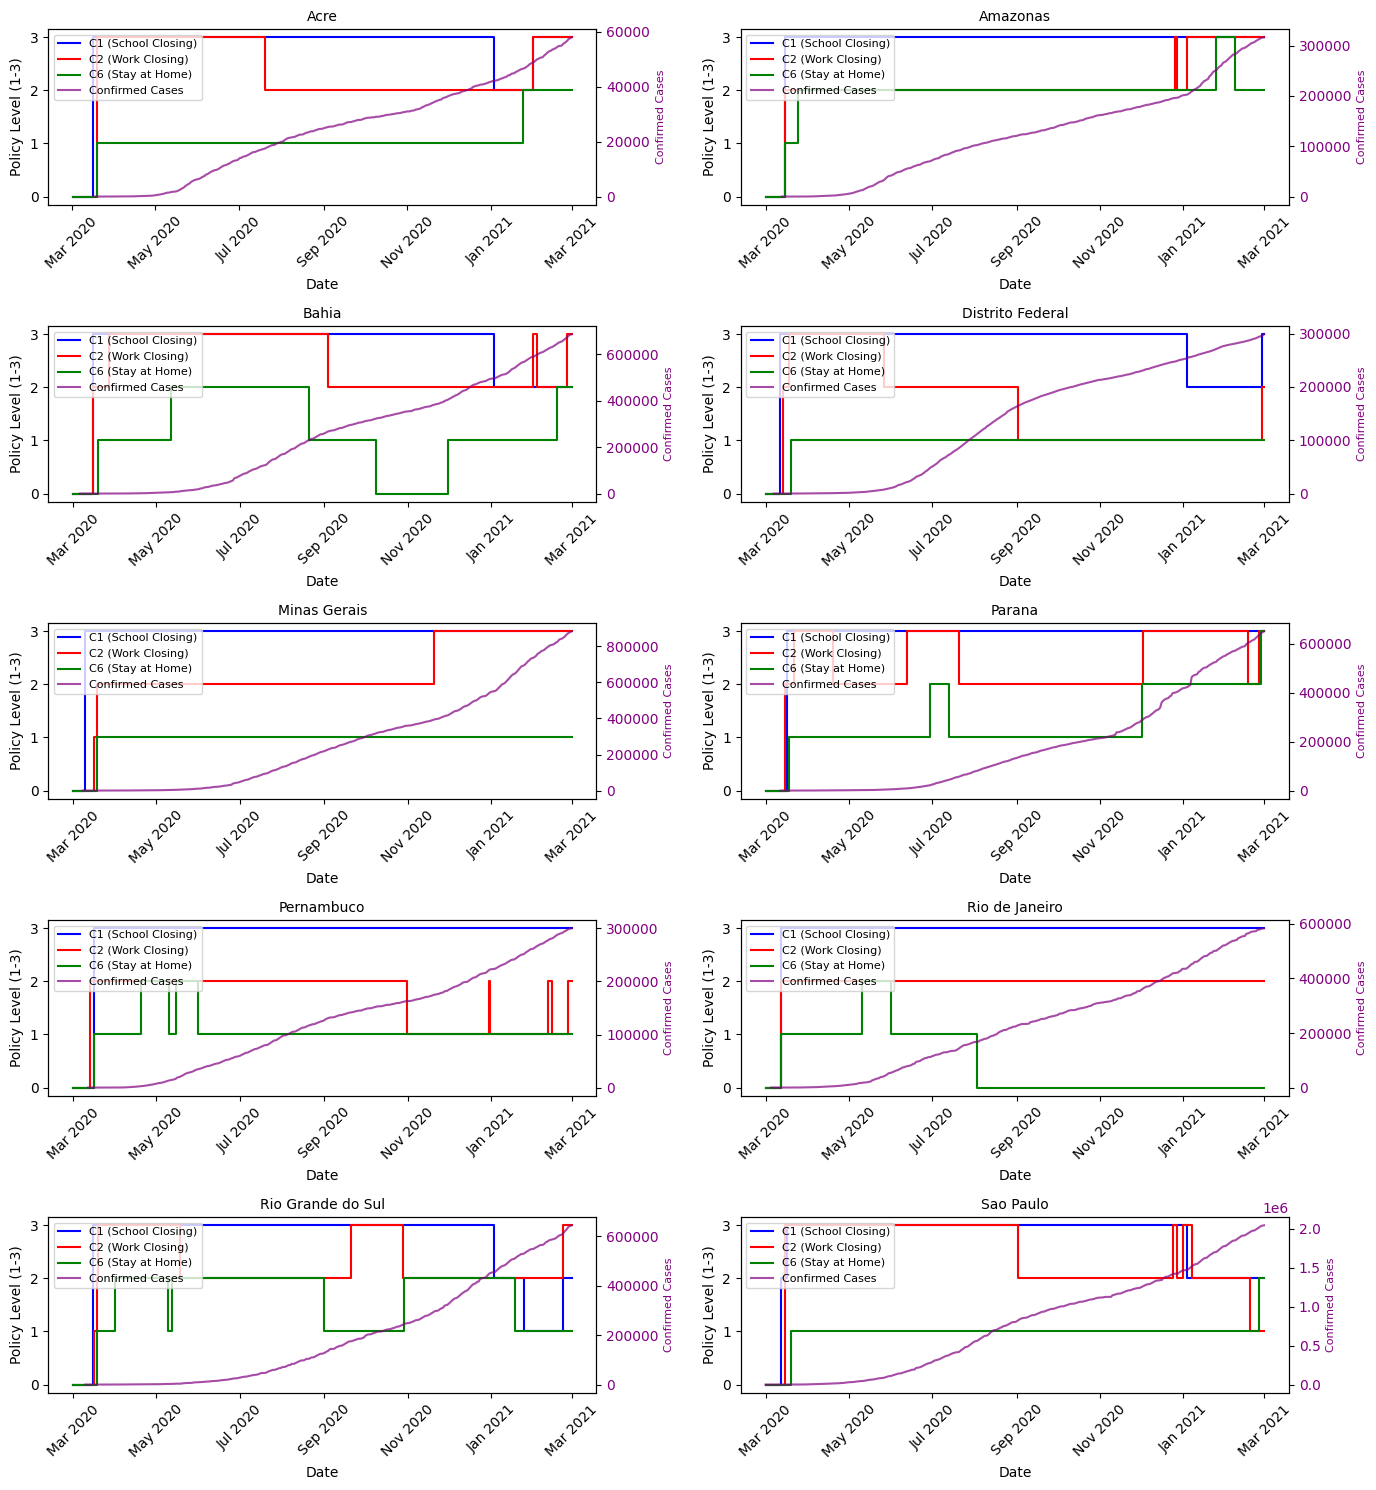

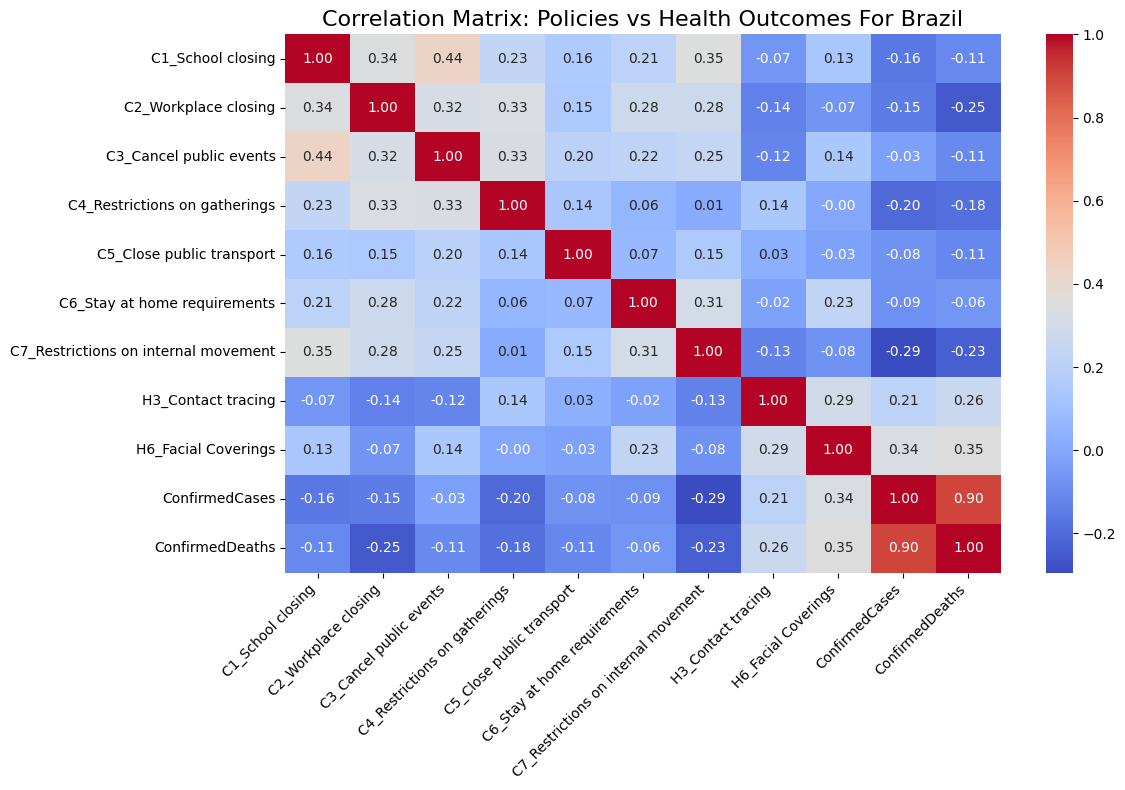

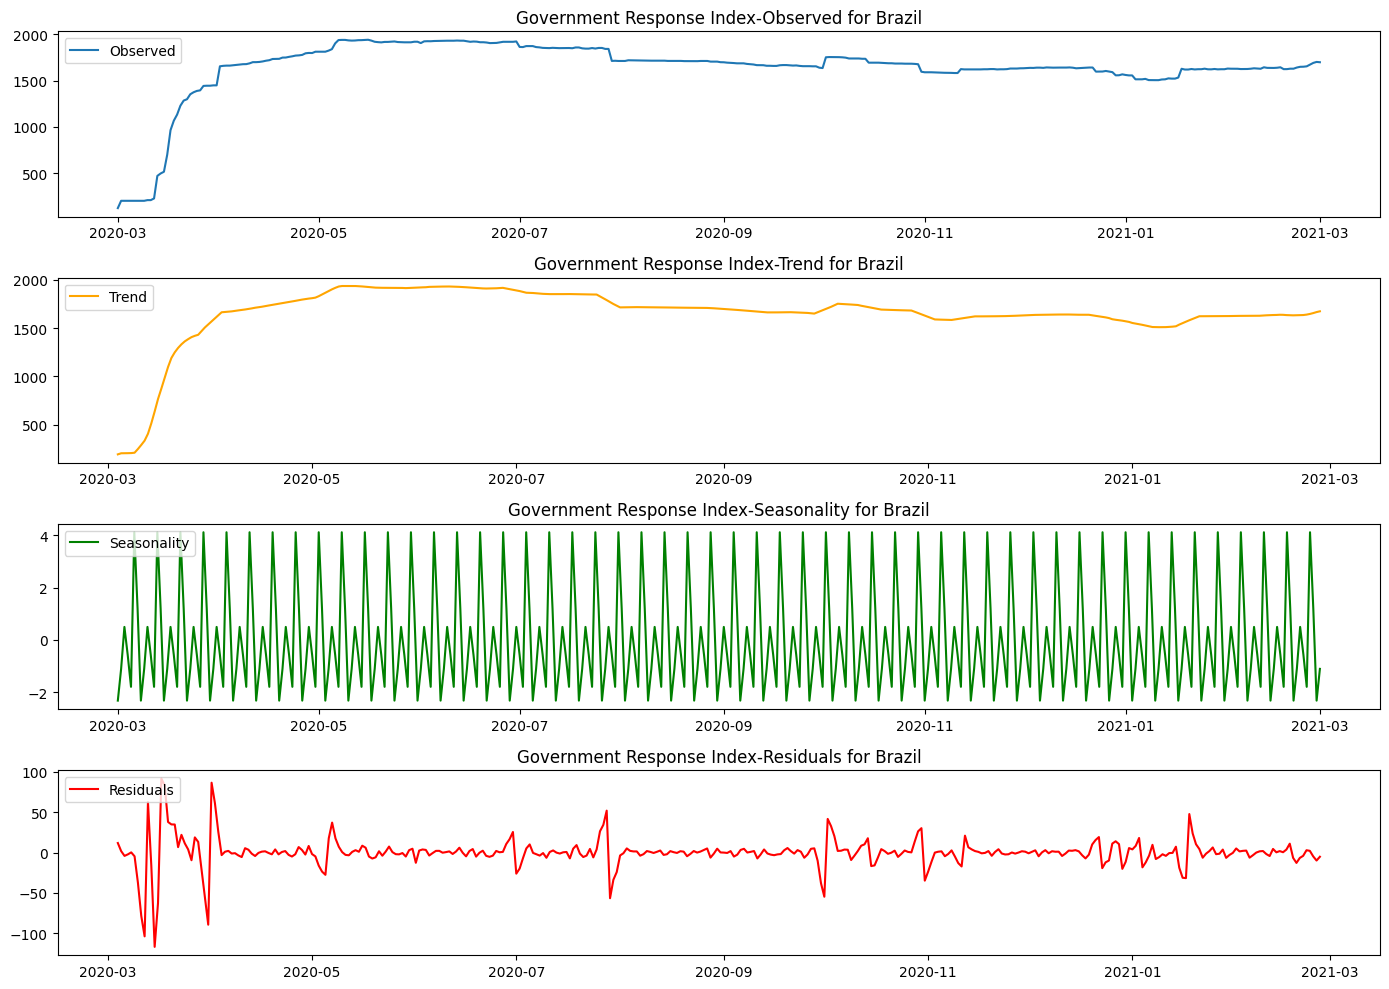

Trend Component Summary:
count     360.000000
mean     1653.994393
std       296.214586
min       191.075714
25%      1624.515000
50%      1680.062143
75%      1797.463571
max      1937.210000
Name: trend, dtype: float64

Seasonal Component Summary:
count    366.000000
mean      -0.009359
std        2.026719
min       -2.318991
25%       -1.792259
50%       -0.574456
75%        1.182829
max        4.112989
Name: seasonal, dtype: float64

Residual Component Summary:
count    360.000000
mean      -0.052549
std       18.690335
min     -116.881009
25%       -3.751651
50%        0.342805
75%        3.342308
max       91.822381
Name: resid, dtype: float64


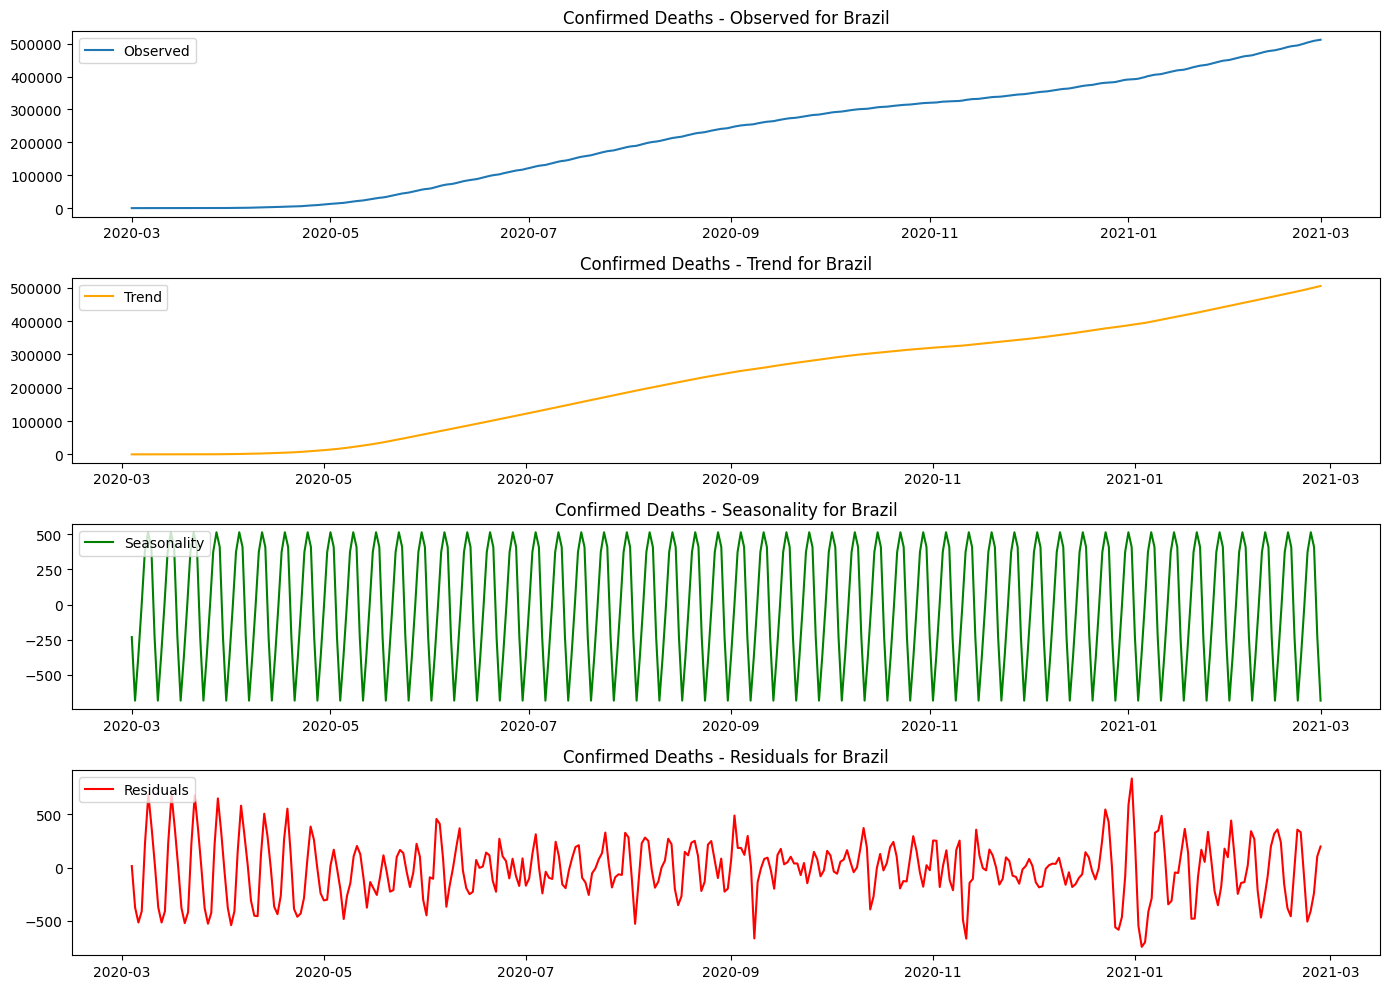

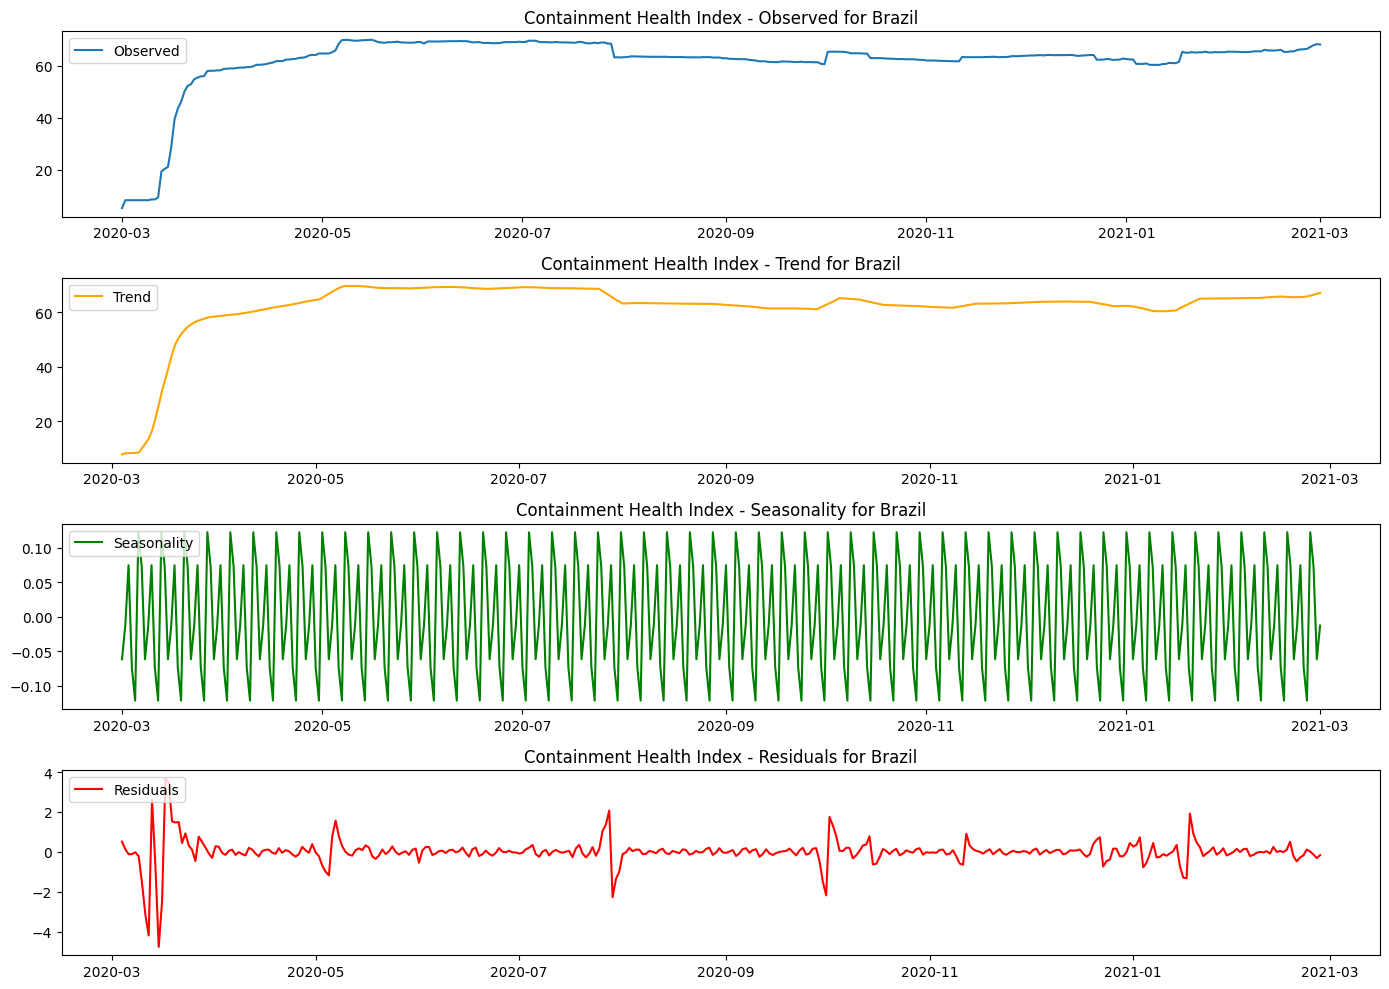

Deaths Trend Component Summary:
count       360.000000
mean     221181.680952
std      156985.741935
min           0.000000
25%       62891.785714
50%      243258.142857
75%      345243.892857
max      505593.000000
Name: trend, dtype: float64

Containment Index Trend Component Summary:
count    360.000000
mean      62.212232
std       10.304859
min        7.823488
25%       62.045548
50%       63.374617
75%       65.905383
max       69.694898
Name: trend, dtype: float64


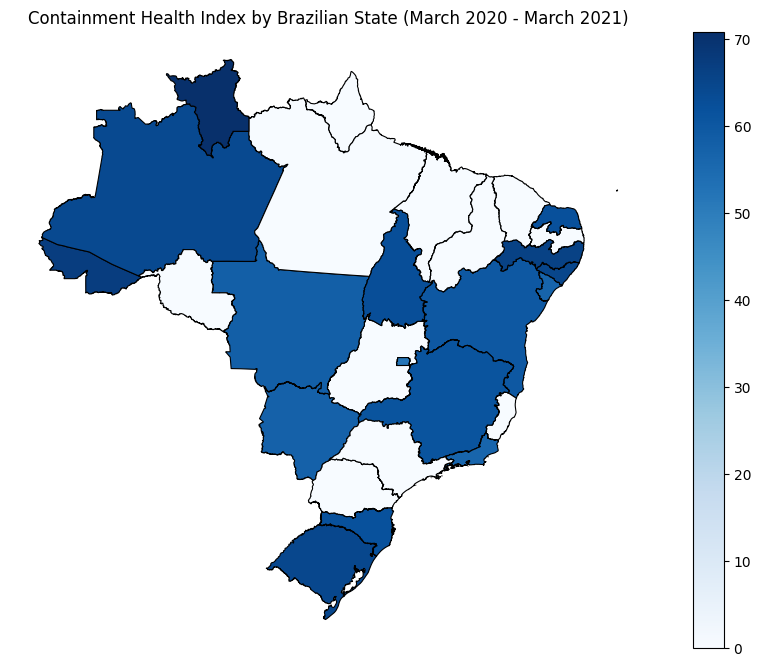

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import files
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import folium
import geopandas as gpd
from folium.plugins import HeatMap

uploaded = files.upload()

df = pd.read_csv("Data - Brazil.csv", parse_dates=['Date'])
df['Date'] = pd.to_datetime(df['Date'])

start_date = '2020-03-01'
end_date = '2021-03-01'
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
print(df.head())
print(df.info())

print(df.describe())

df.isnull().sum()
df.duplicated()
if df['Date'].isna().any():
    print("Invalid dates found. Correct them before plotting!")


columns_to_drop = [
    'C1_Flag', 'C2_Flag', 'C3_Flag', 'C4_Flag', 'C5_Flag', 'C6_Flag', 'C7_Flag', 'E1_Flag',
    'H1_Flag', 'H7_Flag', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures',
    'E4_International support', 'M1_Wildcard', 'V2D_Medically/ clinically vulnerable (Non-elderly)',
    'EconomicSupportIndexForDisplay'
]
df = df.drop(columns=columns_to_drop)

subset_states = [
    'Acre', 'Amazonas', 'Bahia', 'Distrito Federal', 'Minas Gerais',
    'Parana', 'Pernambuco', 'Rio de Janeiro', 'Rio Grande do Sul', 'Sao Paulo'
]
subset_data = df[df['RegionName'].isin(subset_states)]

n_states = len(subset_states)
rows = (n_states // 2) + (n_states % 2)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 3))
axes = axes.flatten()

# Plot for each state
for i, state in enumerate(subset_states):
    ax = axes[i]
    state_data = subset_data[subset_data['RegionName'] == state]

    if not state_data.empty:
        ax.step(state_data['Date'], state_data['C1_School closing'], label="C1 (School Closing)", color="blue", where="mid")
        ax.step(state_data['Date'], state_data['C2_Workplace closing'], label="C2 (Work Closing)", color="red", where="mid")
        ax.step(state_data['Date'], state_data['C6_Stay at home requirements'], label="C6 (Stay at Home)", color="green", where="mid")

        ax2 = ax.twinx()
        ax2.plot(state_data['Date'], state_data['ConfirmedCases'], label="Confirmed Cases", color="purple", linestyle='-', alpha=0.7)
        ax2.set_ylabel("Confirmed Cases", color="purple", fontsize=8)
        ax2.tick_params(axis='y', labelcolor="purple")

    else:
        ax.text(0.5, 0.5, "No data available", fontsize=12, ha='center', va='center')

    ax.set_title(state, fontsize=10)
    ax.set_ylabel("Policy Level (1-3)")
    ax.set_xlabel("Date")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8)

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc="upper left")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

state_data = df.dropna(subset=['RegionName'])
state_filtered_data = state_data[
    (state_data['Date'] >= pd.to_datetime('2020-03-01')) & (state_data['Date'] <= pd.to_datetime('2021-03-31'))
]

state_aggregated = state_filtered_data.groupby('RegionName').agg({
    'ContainmentHealthIndexForDisplay': 'mean',
    'ConfirmedCases': 'max',
    'ConfirmedDeaths': 'max'
}).reset_index()

# Calculate Case Fatality Rate (CFR) and sort states
state_aggregated['CaseFatalityRate'] = state_aggregated['ConfirmedDeaths'] / state_aggregated['ConfirmedCases']
state_aggregated = state_aggregated.sort_values(by='ContainmentHealthIndexForDisplay', ascending=False).head(20)

top_states = state_aggregated['RegionName']
top_states_data = state_filtered_data[state_filtered_data['RegionName'].isin(top_states)]

correlation_data = top_states_data[
    [
        'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
        'C4_Restrictions on gatherings', 'C5_Close public transport',
        'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
        'H3_Contact tracing', 'H6_Facial Coverings',
        'ConfirmedCases', 'ConfirmedDeaths'
    ]
]

correlation_data = correlation_data.dropna()

correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
    xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns
)
plt.title('Correlation Matrix: Policies vs Health Outcomes For Brazil', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
subset_data = df[['Date', 'GovernmentResponseIndexForDisplay']].groupby('Date').sum().reset_index()

# Decompose the time series
decomposition = seasonal_decompose(subset_data.set_index('Date')['GovernmentResponseIndexForDisplay'], model='additive')

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.title('Government Response Index-Observed for Brazil')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Government Response Index-Trend for Brazil')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Government Response Index-Seasonality for Brazil')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Government Response Index-Residuals for Brazil')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("Trend Component Summary:")
print(decomposition.trend.describe())
print("\nSeasonal Component Summary:")
print(decomposition.seasonal.describe())
print("\nResidual Component Summary:")
print(decomposition.resid.describe())

df_grouped = df.groupby('Date').agg({
    'ConfirmedDeaths': 'sum',
    'ContainmentHealthIndexForDisplay': 'mean'
}).reset_index()

df_grouped = df_grouped.set_index('Date').resample('D').agg({
    'ConfirmedDeaths': 'sum',
    'ContainmentHealthIndexForDisplay': 'mean'
}).reset_index()

# Decompose the time series for ConfirmedDeaths
decomposition_deaths = seasonal_decompose(df_grouped.set_index('Date')['ConfirmedDeaths'], model='additive')

# Decompose the time series for ContainmentHealthIndex_Average
decomposition_index = seasonal_decompose(df_grouped.set_index('Date')['ContainmentHealthIndexForDisplay'], model='additive')

# Plot the components for ConfirmedDeaths
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition_deaths.observed, label='Observed')
plt.title('Confirmed Deaths - Observed for Brazil')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition_deaths.trend, label='Trend', color='orange')
plt.title('Confirmed Deaths - Trend for Brazil')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition_deaths.seasonal, label='Seasonality', color='green')
plt.title('Confirmed Deaths - Seasonality for Brazil')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition_deaths.resid, label='Residuals', color='red')
plt.title('Confirmed Deaths - Residuals for Brazil')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Plot the components for ContainmentHealthIndex_Average
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition_index.observed, label='Observed')
plt.title('Containment Health Index - Observed for Brazil')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition_index.trend, label='Trend', color='orange')
plt.title('Containment Health Index - Trend for Brazil')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition_index.seasonal, label='Seasonality', color='green')
plt.title('Containment Health Index - Seasonality for Brazil')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition_index.resid, label='Residuals', color='red')
plt.title('Containment Health Index - Residuals for Brazil')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("Deaths Trend Component Summary:")
print(decomposition_deaths.trend.describe())
print("\nContainment Index Trend Component Summary:")
print(decomposition_index.trend.describe())

#Map

df = pd.read_csv('Data - Brazil.csv', parse_dates=['Date'])


start_date = '2020-03-01'
end_date = '2021-03-01'
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

columns_to_drop = [
    'C1_Flag', 'C2_Flag', 'C3_Flag', 'C4_Flag', 'C5_Flag', 'C6_Flag', 'C7_Flag', 'E1_Flag',
    'H1_Flag', 'H7_Flag', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures',
    'E4_International support', 'M1_Wildcard',
    'EconomicSupportIndexForDisplay'
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

state_data = df.dropna(subset=['RegionName'])

state_aggregated = state_data.groupby('RegionName').agg({
    'ContainmentHealthIndexForDisplay': 'mean',
    'ConfirmedCases': 'max',
    'ConfirmedDeaths': 'max'
}).reset_index()

state_aggregated['CaseFatalityRate'] = state_aggregated['ConfirmedDeaths'] / state_aggregated['ConfirmedCases']

brazil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

brazil = brazil.rename(columns={'name': 'RegionName'})

map_data = brazil.merge(state_aggregated, on='RegionName', how='left')

map_data['ContainmentHealthIndexForDisplay'] = map_data['ContainmentHealthIndexForDisplay'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
map_data.plot(column='ContainmentHealthIndexForDisplay', cmap='Blues', linewidth=0.8, ax=ax,
              edgecolor='black', legend=True, missing_kwds={'color': 'lightgrey', 'label': 'No Data'})

plt.title('Containment Health Index by Brazilian State (March 2020 - March 2021)')
plt.axis('off')
plt.show()